# Implementing an Autoencoder in PyTorch
[Implementing an Autoencoder in PyTorch](https://www.geeksforgeeks.org/implementing-an-autoencoder-in-pytorch/?ref=lbp)

只使用线性层，构建一个自动编码器

In [1]:
import torch
from torchvision import datasets
from torchvision import transforms
import matplotlib.pyplot as plt
import sys
import torch.nn as nn

print("Python版本信息:")
print(sys.version)

print("torch版本信息:")
print(torch.__version__)

print("python路径:")
print(sys.executable)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device", device)

Python版本信息:
3.10.6 (main, Oct 24 2022, 16:07:47) [GCC 11.2.0]
torch版本信息:
1.13.1+cu117
python路径:
/opt/anaconda3/envs/sd-webui/bin/python
device cuda


In [2]:
batch_size_train = 32 # We use a small batch size here for training
batch_size_test = 32 #
latent_dim = 9

# define how image transformed
image_transform = transforms.Compose([
                               transforms.ToTensor()
                             ])
#image datasets
train_dataset = datasets.MNIST('dataset/', train=True, download=True,transform=image_transform)
test_dataset = datasets.MNIST('dataset/', train=False, download=True,transform=image_transform)
#data loaders
train_loader = torch.utils.data.DataLoader(train_dataset,batch_size=batch_size_train,shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,batch_size=batch_size_test, shuffle=True)

In [3]:
# 28*28 ==> 9 ==> 28*28
class AE(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
        # 28*28 = 784 ==> 128 ==> 64 ==> 36 ==> 18 ==> 9
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 36),
            nn.ReLU(),
            nn.Linear(36, 18),
            nn.ReLU(),
            nn.Linear(18, latent_dim),
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 18),
            nn.ReLU(),
            nn.Linear(18, 36),
            nn.ReLU(),
            nn.Linear(36, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, 28*28),
            nn.Sigmoid()
        )
    def forward(self, x):
        en = self.encoder(x)
        de = self.decoder(en)
        return de

In [4]:
model = AE()
model.cuda()

loss_function = nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(),
                             lr = 1e-1,
                             weight_decay = 1e-8)

In [5]:
epochs = 100
outputs = []

for epoch in range(epochs):
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.to(device)
        x = x.reshape(-1, 28*28)
        
        reconstructed = model(x)
        
        loss = loss_function(reconstructed, x)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if batch_idx % 500 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(x), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
        
    outputs.append((epochs, x, reconstructed))      

torch.save(model.state_dict(), './linear_autoencoder.pth')   

Train Epoch: 0 [0/60000 (0%)]	Loss: 0.231413
Train Epoch: 0 [16000/60000 (27%)]	Loss: 0.071023
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.064934
Train Epoch: 0 [48000/60000 (80%)]	Loss: 0.068737
Train Epoch: 1 [0/60000 (0%)]	Loss: 0.071708
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.065832
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.065781
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.067080
Train Epoch: 2 [0/60000 (0%)]	Loss: 0.064386
Train Epoch: 2 [16000/60000 (27%)]	Loss: 0.065247
Train Epoch: 2 [32000/60000 (53%)]	Loss: 0.066276
Train Epoch: 2 [48000/60000 (80%)]	Loss: 0.068626
Train Epoch: 3 [0/60000 (0%)]	Loss: 0.069826
Train Epoch: 3 [16000/60000 (27%)]	Loss: 0.066343
Train Epoch: 3 [32000/60000 (53%)]	Loss: 0.073530
Train Epoch: 3 [48000/60000 (80%)]	Loss: 0.070760
Train Epoch: 4 [0/60000 (0%)]	Loss: 0.067593
Train Epoch: 4 [16000/60000 (27%)]	Loss: 0.067713
Train Epoch: 4 [32000/60000 (53%)]	Loss: 0.067341
Train Epoch: 4 [48000/60000 (80%)]	Loss: 0.073871
Train Epoch: 5 [0/60000 (

/tmp/ipykernel_3016887/1653866888.py:9: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,8,i+1)


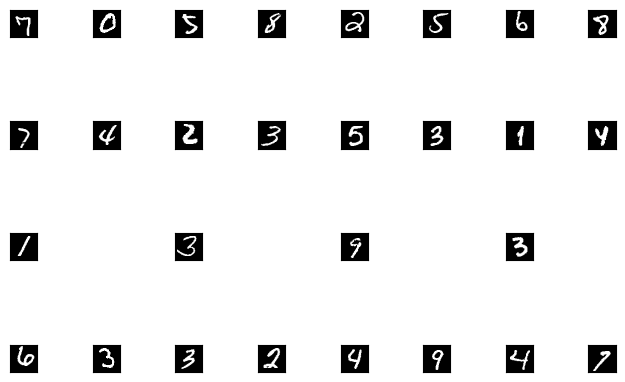

In [6]:
# for i, item in enumerate(x):
   
#   # Reshape the array for plotting
#   item = item.reshape(-1, 28, 28)
#   plt.imshow(item[0].cpu().numpy())

fig = plt.figure()
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.tight_layout()
  item = x[i].reshape(-1, 28, 28)
  plt.imshow(item[0].cpu().numpy(), cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])
  

/tmp/ipykernel_3016887/1451719922.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(4,8,i+1)


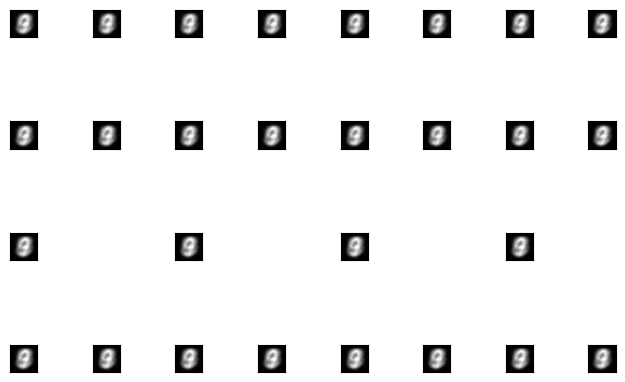

In [7]:
# for i, item in enumerate(reconstructed):
#   item = item.reshape(-1, 28, 28)
#   plt.imshow(item[0].cpu().detach().numpy())
  
fig = plt.figure()
for i in range(32):
  plt.subplot(4,8,i+1)
  plt.tight_layout()
  item = reconstructed[i].reshape(-1, 28, 28)
  plt.imshow(item[0].cpu().detach().numpy(), cmap='gray', interpolation='none')
  plt.xticks([])
  plt.yticks([])